## Midterm Project: Predicting Arrival Delay for Airlines
    by Elie Saliba and Kevin Ting

### Task: 

Build a ML model to predict delays on flights (**ARR_DELAY**) from first 7 days of 2020.

### Approach: 
    1) Load data
    2) Wrangle data: Check for sparse features to remove them
    3) Wrangle data: Remove columns that will not be available for evaluation
    4) Wrangle data: Check for columns with a few missing values to impute with zero, mean or median
    5) Wrangle data: Encode categorical values to numerical values
    6) Exploratory analyss: Visualize data distribution with histograms
    7) Exploratory analyss: Use measures of central tendency and IQR to understand data at various positions
    
    8) Variable interdependence: Infer multicollinearity of data through correlation matrix
    9) Feature selection: Remove redundant variables (i.e. columns that refer to the same thing e.g. ID)
    10) Feature engineering: Remove highly collinear variables (i.e. correlation > 0.8)
    11) Feature engineering: Reduce data dimension to the variables that most explain variation in target variable
    12) Modeling building: Random forest is chosen for machine learning modeling
    13) Model comparison: Random forest modeling with original raw data (PART 2) and PCA transformed data (PART 3)
    14) Machine learning process:
        (a) Train/test data: Split data for training and testing
        (b) Model creation: Create models in a grid search for a combination of parameters
        (c) Model selection: Use 10-fold cross validation to evaluate model performance and select the best one
        (c) Final Model training: Use parameters of the best model from above to train on entire train set
        (d) Final Model evaluation: Use 10-fold cross validation for average error on 10 folds of training data
        (e) Final Model performance evaluation: Use confusion matrix, Precision, Recall, ROC to evaluate performance

### Environment Setup

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### 1. Load Data

In [2]:
df = pd.read_csv("data/airline_sample_150k.csv")
df.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-01,AA,AA_CODESHARE,AA,5241,OH,N703PS,5241,11057,CLT,...,562,25.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2019-01-01,NK,NK,NK,115,NK,N525NK,115,10821,BWI,...,1491,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN


### 2. Wrangle data: Check for sparse features to remove them

In [3]:
print(f'Dimension: {len(df.columns)}')
print(f'Sparsity per variable:\n{(len(df.index) - df.count()) / len(df.index) * 100}')

Dimension: 42
Sparsity per variable:
fl_date                  0.000000
mkt_unique_carrier       0.000000
branded_code_share       0.000000
mkt_carrier              0.000000
mkt_carrier_fl_num       0.000000
op_unique_carrier        0.000000
tail_num                 0.302857
op_carrier_fl_num        0.000000
origin_airport_id        0.000000
origin                   0.000000
origin_city_name         0.000000
dest_airport_id          0.000000
dest                     0.000000
dest_city_name           0.000000
crs_dep_time             0.000000
dep_time                 1.595507
dep_delay                1.623211
taxi_out                 1.681138
wheels_off               1.681138
wheels_on                1.739694
taxi_in                  1.739694
crs_arr_time             0.000000
arr_time                 1.701916
arr_delay                1.929216
cancelled                0.000000
cancellation_code       98.344677
diverted                 0.000000
dup                      0.000000
crs_elapsed

In [4]:
# drop features that have >80% sparsity
df = df.iloc[:, :-9]
df = df.drop('cancellation_code', axis=1)

# drop features that won't be available for evaluation
df = df.drop([
    'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
    'arr_time', 'cancelled', 'diverted', 'actual_elapsed_time','air_time'], 
    axis=1
)

# drop ARR_DELAY rows with NaN
df = df.drop(df[df['arr_delay'].isna()].index).reset_index(drop=True)

print(f'Dimension reduces to: {len(df.columns)}')

Dimension reduces to: 21


In [5]:
# converting FL_DATE to datetime type for easy wrangling
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d')

# creating MONTH from FL_DATE
months = [df['fl_date'][i].month for i in range(len(df['fl_date']))]
df.insert(1, 'month', value=months)

# creating WEEKDAY from FL_DATE
weekdays = [df['fl_date'][i].weekday() for i in range(len(df['fl_date']))]
df.insert(2, 'weekday', value=weekdays)

print(f'Dimension increase to: {len(df.columns)}')

Dimension increase to: 23


### Exploratory Analysis

<Figure size 1080x360 with 0 Axes>

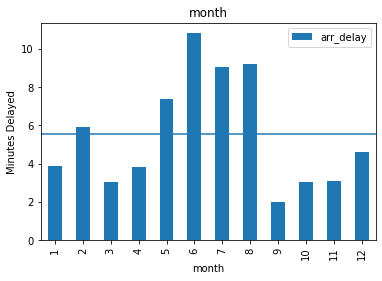

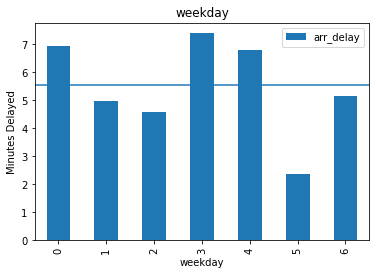

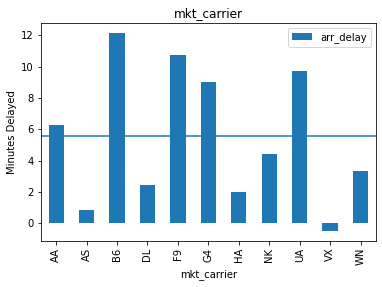

In [6]:
# average delay of flights per catergory compare to overall delay from all records
avg_delay = df.arr_delay.mean()
categories = ['month', 'weekday', 'mkt_carrier']

for i, pred in enumerate(categories):
    plt.figure(i, figsize=(15, 5))
    group = df.groupby(pred, as_index=False).mean()[[pred, 'arr_delay']]
    group.sort_values(by=pred, inplace=True)
    group.plot.bar(x=pred, y='arr_delay')
    plt.axhline(y=avg_delay)
    plt.ylabel('Minutes Delayed')
    plt.title(pred)

In [7]:
# transform categorical features into dummies
cols_dummies = pd.get_dummies(df['mkt_carrier'])

In [8]:
# extract numerical features
cols_num = df[['month', 'weekday', 'arr_delay', 'distance']]

# combine numerical and categorical (dummies) features into final dataframe
df = pd.concat([cols_num, cols_dummies], axis=1)

print(f'Final Dimension: {len(df.columns)}')

Final Dimension: 15


In [9]:
df.head(2)

,month,weekday,arr_delay,distance,AA,AS,B6,DL,F9,G4,HA,NK,UA,VX,WN
0,1,1,29.0,562,1,0,0,0,0,0,0,0,0,0,0
1,1,1,15.0,1491,0,0,0,0,0,0,0,1,0,0,0


### (future step reference) LinearSVR
[guide](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR)

from sklearn.datasets import make_friedman1

from sklearn.feature_selection import RFE

from sklearn.svm import SVR

X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)

estimator = SVR(kernel="linear")

selector = RFE(estimator, n_features_to_select=5, step=1)

selector = selector.fit(X, y)

selector.support_
> array([ True,  True,  True,  True,  True, False, False, False, False,
       False])
       
selector.ranking_

> array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

In [10]:
# dropping all cancelled flights since they will skew the model
df = df[df['cancelled'] != 1]

# same reasoning for dropping diverted flights
df = df[df['diverted'] != 1]

KeyError: 'cancelled'

In [ ]:
# dropping the no_name column comprised of commas since this is a csv
df = df.drop('no_name', axis = 1)

In [ ]:
# getting rid of unimportant columns

df = df.drop(axis = 1, labels = ['branded_code_share', 'mkt_carrier_fl_num', 'tail_num', 'op_carrier_fl_num', 'cancelled', 'cancellation_code', 'diverted', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime'])

In [ ]:
df.head(2)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df['dep_delay'], df['arr_delay'], alpha = 0.4)
plt.title('Departure Delay VS Arrival Delay')
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')

plt.show()
# this shows a strong correlation between dep_delay and arr_delay as expected

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [ ]:
# checking for and dropping null values in arr_delay
df["arr_delay"].isnull().sum()
df.dropna(subset = ["arr_delay"], inplace = True)

In [ ]:
arr_delay_zs = stats.zscore(df["arr_delay"], nan_policy = 'omit')
arr_delay_zs3 = arr_delay_zs < 3

df['arr_delay_zs'] = df['arr_delay'][arr_delay_zs3]

In [ ]:
df['arr_delay_zs'].head(2)

In [ ]:
df["arr_delay_zs"].describe()

In [ ]:
histplot = sns.histplot(data = df["arr_delay_zs"])

In [ ]:
delay_arr = df['arr_delay_zs'].fillna(0).to_numpy()

# reshaping the data into an array to pass into Shapiro Test
delay_arr.reshape(-1, 1)

In [ ]:
shapiro_test = stats.shapiro(delay_arr)
shapiro_test

In [ ]:
# This was an attempt to remove 0's before log transformation by adding a constant slightly larger than the min value
# in arr_delay

#df["arr_delay"].min()
#df["arr_delay_const"] = df["arr_delay"] + 64.001

In [ ]:
# df["arr_delay_log"] = df["arr_delay_zs"].apply(np.log1p).fillna(0)

In [ ]:
# df["arr_delay_log"].head()

In [ ]:
# Somehow getting Nan values in statistic here

# shapiro_test = stats.shapiro(df['arr_delay_log'])
# shapiro_test

In [ ]:
# histplot = sns.histplot(data = df["arr_delay_log"])

In [ ]:
df.head(2)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [ ]:
# splitting the date on the hyphen to easily access the month
spl_date = [date.split('-')[1] for date in df['fl_date']]

In [ ]:
df['months'] = spl_date
df.head(2)

In [ ]:
# Reordering the DF by saving the columns and then adding them after the months column

cols = list(df.columns)
cols.pop(cols.index('fl_date'))
cols.pop(cols.index('months'))
df = df[['fl_date','months'] + cols]
df.head(2)

In [ ]:
# Changing months dtype to int so that we can perform numerical operations on the values
df['months'] = df['months'].astype(int)

In [ ]:
df.groupby(by = 'months').mean()[['arr_delay']]

In [ ]:
month_vs_delay = sns.barplot(x = df['months'], y = df['arr_delay'], ci = None)

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [ ]:
# getting zscore for taxi times to use for outlier omission
taxi_zs = stats.zscore(df["taxi_out"], nan_policy = 'omit')

In [ ]:
# assigning a variable to booleans where taxi_zs is less than 3
taxi_zs_3 = taxi_zs < 3

In [ ]:
df['taxi_out_zs'] = df['taxi_out'][taxi_zs_3]
df.shape

In [ ]:
taxi_graph = sns.scatterplot(x = df['dep_time'], y = df['taxi_out_zs'])

#consider binning times here
#consider 2d distribution maps

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [ ]:
# assuming that the question here is asking for proportion of delays caused by depratrue delays

df.head()
# we want to see proportion of dep_delay > 0 resulting in arr_delay > 0
df_delarr = df.loc[(df['dep_delay'] > 0) & (df['arr_delay'] > 0)]
df_delarr = df_delarr[['dep_delay', 'arr_delay']]
len(df_delarr),len(df.loc[df['arr_delay'] > 0])

In [ ]:
# avg percentage of delays  = (2277/3245) * 100


#### **Task 6**: How many states cover 50% of US air traffic? 

In [ ]:
df.head(2)

In [ ]:
#ploot = sns.scatterplot(x = df["dep_delay"], y = )

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [ ]:
#df["dep_delay"] = df["dep_delay"][(np.abs(stats.zscore(df["dep_delay"])) < 3)]

df['speed'] = df['distance'] / df['air_time']

#ztest ,pval = stests.ztest(df['bp_before'], x2=None, value=156)
#print(float(pval))
#if pval<0.05:
#    print("reject null hypothesis")
#else:
#    print("accept null hypothesis")

In [ ]:
#df_w_delay = df.loc[(df['dep_delay'] > 0)]
#df_w_delay = df_w_delay[['dep_delay', 'speed']]

#df_no_delay = df.loc[(df['dep_delay'] <= 0)]
#df_no_delay = df_no_delay[['dep_delay', 'speed']]

In [ ]:
#fig, ax = plt.subplots(figsize=(8, 8))

# add the plots for each dataframe
#sns.regplot(y='dep_delay', x='speed', data=df_w_delay, fit_reg=True, ci=None, ax=ax, label='Speed with delay')
#sns.regplot(y='dep_delay', x='speed', data=df_no_delay, fit_reg=True, ci=None, ax=ax, label='Speed without delay')
#ax.set(xlabel='Speed', ylabel='Departure Delay')
#ax.legend()
#plt.show()

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [ ]:
# we want to bin the data based on air_time feature
# i will take 0-3 hours to be SHORT, 3-6 hours to be MEDIUM and 6+ hours to be long

bins = [0, 180, 360, np.inf]
labels = ['SHORT', 'MEDIUM', 'LONG']
df['time_bins'] = pd.cut(df['air_time'], bins=bins, labels=labels)
#df.head()
#df['time_bins']
plot = sns.scatterplot(data = df, x = 'air_time', y = 'dep_time', hue = df['time_bins'], ci = None)

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [ ]:
df['mkt_unique_carrier'].nunique()

In [ ]:
df.head(2)

In [ ]:
df['total_delay'] = (df['carrier_delay'] + df['weather_delay']
             + df['nas_delay'] + df['security_delay'] + df['late_aircraft_delay'])

df_delays = df.loc[(df['total_delay'] != np.NaN)]
df['total_delay'].fillna(0, inplace=True)
df['total_delay'].head()

In [ ]:
carrier_group = df_delays['carrier_delay'].groupby(df_delays['mkt_unique_carrier']).mean()
weather_group = df_delays['weather_delay'].groupby(df_delays['mkt_unique_carrier']).mean()
nas_group = df_delays['nas_delay'].groupby(df_delays['mkt_unique_carrier']).mean()
security_group = df_delays['security_delay'].groupby(df_delays['mkt_unique_carrier']).mean()
late_group = df_delays['late_aircraft_delay'].groupby(df_delays['mkt_unique_carrier']).mean()

w_bottom = carrier_group.values
n_bottom = w_bottom + weather_group.values
s_bottom = n_bottom + nas_group.values
l_bottom = s_bottom + security_group.values

x = carrier_group.index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),carrier_group.values, align='center', label='Carrier Delay')
ax.bar(np.arange(len(x)),weather_group.values, align='center', bottom=w_bottom, label='Weather Delay')
ax.bar(np.arange(len(x)),nas_group.values, align='center', bottom=n_bottom, label='NAS Delay')
ax.bar(np.arange(len(x)),security_group.values, align='center', bottom=s_bottom, label='Security Delay')
ax.bar(np.arange(len(x)),late_group.values, align='center', bottom=l_bottom, label='Late Aircraft Delay')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Departure Delay in minutes')

plt.legend()
plt.show()

In [ ]:
df_delays = df_delays[df_delays['total_delay'] > 0]

In [ ]:
carrier_flights = df['mkt_unique_carrier'].groupby(df['mkt_unique_carrier']).count()
carrier_delays = df_delays['total_delay'].groupby(df_delays['mkt_unique_carrier']).count()
carrier_avg_time = df['air_time'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_dist = df['distance'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_delay = df['total_delay'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_taxiIn = df['taxi_in'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_taxiOut = df['taxi_out'].groupby(df['mkt_unique_carrier']).mean()

In [ ]:
summary_table_carrier = pd.concat([carrier_flights, carrier_delays, carrier_avg_time, carrier_avg_dist,
                                   carrier_avg_delay, carrier_avg_taxiIn, carrier_avg_taxiOut], axis=1)

summary_table_carrier.columns = ['Total Flights', 'Total Delays', 'Avg Flight Time (mins)',
                         'Avg Flight Distance', 'Avg Flight Delay (mins)', 
                         'Avg Taxi-In (mins)', 'Avg Taxi-Out (mins)']

summary_table_carrier

In [ ]:
columns = ['fl_date', 'mkt_carrier', 'origin', 'dest', 'distance', 'arr_delay']
data = pd.read_csv('data/airline_sample_10k.csv', usecols=columns)

In [ ]:
cat_cols = ['mkt_carrier', 'origin', 'dest']
cols_dummies = pd.get_dummies(data[cat_cols])

In [ ]:
data = data.drop(cat_cols, axis=1)

In [ ]:
data_tf = pd.concat([data, cols_dummies], axis=1)

In [ ]:
data_tf = data_tf.dropna()

In [ ]:
data_tf.head()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
X = data_tf.drop(['arr_delay','fl_date'], axis = 1)
y = df['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

new_model = RandomForestRegressor()
params_grid = {'n_estimators' : [1, 5, 10]}

#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

models = GridSearchCV(new_model, params_grid)
models.fit(X_train, y_train)
# report performance
#print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
len(X_train),len(y_train)

In [ ]:
be_models = models.best_estimator_

In [ ]:
be_models.score(X_train, y_train)

In [ ]:
df2 = pd.read_csv("data/flights_test_5k.csv")

In [ ]:
df2

In [ ]:
X_test = df2.drop('arr_delay', axis = 1)

In [ ]:
df2.columns

In [ ]:
#clf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

# sum(y_test)
# clf.score(X_test, y_test)

#y_predicted = clf.predict(X_test)
#confusion = confusion_matrix(y_test, y_predicted)
#confusion
#sum(y_predicted)

#print('Recall: {:.3f}'.format(recall_score(y_test, y_predicted)))
#print('Precision: {:.3f}'.format(precision_score(y_test, y_predicted)))
#print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_predicted)))
#print('F1: {:.3f}'.format(f1_score(y_test, y_predicted)))
#confusion = confusion_matrix(y_test, y_predicted)
#print(confusion)
#print('Feature importances: {}'.format(clf.feature_importances_))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

lr = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid_lr = GridSearchCV(lr, param_grid = grid_values, scoring = 'recall').fit(X_train_scaled, y_train)
print(grid_lr.cv_results_['mean_test_score'].reshape(9,2))